# Model Fitting: ESS (Elliptical Slice Sampling)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
import time
import timeit

import scipy.stats
# import scipy.stats.norm as norm
import pandas as pd
import pymc as pm

import re
import numpy as np
import pickle as pickle

In [2]:
player_info = pd.read_csv("clean-data/player_info_pergame.csv")
game_outcomes = pd.read_csv("clean-data/game_outcomes_15-16.csv")

In [3]:
N_players = len(player_info)
N_teams = np.max(game_outcomes['Visitor_Index'].values) + 1
N_games =  len(game_outcomes)

print N_players, N_teams, N_games
print 2 * (N_players + N_teams)

476 30 1230
1012


In [4]:
################# INPUT SECTION ###################
###################################################

########### player indicator for each game ###############
### host_lineup_arr & guest_lineup_arr are (1230 x 476)###
with open("clean-data/host_team_line_up.pkl", "rb") as f:
    host_team_line_up = pickle.load(f)

with open("clean-data/guest_team_line_up.pkl", "rb") as f:
    guest_team_line_up = pickle.load(f)
    
# print len(host_team_line_up[0])
host_lineup_arr = np.array(host_team_line_up)
guest_lineup_arr = np.array(guest_team_line_up)


######### team indicator for each game ########### 
### host_matrix & guest_matrix are (1230 x 30) ###
guest_matrix = np.zeros((game_outcomes.shape[0], np.max(game_outcomes['Visitor_Index']) + 1), dtype = bool)
guest_matrix.shape
host_matrix = np.copy(guest_matrix)

def make_matrix(mat, indices):
    for (i, ind) in enumerate(indices):
        mat[i, ind] = True

make_matrix(host_matrix, game_outcomes['Visitor_Index'].values)
make_matrix(guest_matrix, game_outcomes['Home_Index'].values)


############## Observed data ##################
score_diff = game_outcomes['diff'].values
off_rating = player_info['PTS'].values + player_info['AST'].values
def_rating = player_info['BLK'].values + player_info["STL"].values + player_info['DRB'].values

In [5]:
def split_params(coefs, nplayers, nteams):
    '''
    Split the parameters
    first are the beta0 for each team
    then the beta for each player
    then the gamma0 for each team
    then the gamma for each player'''
    assert(coefs.shape == (2*(nplayers+nteams),))
    
    beta0 = coefs[:nteams]
    beta_player = coefs[nteams:(nplayers + nteams)]
    gamma0 = coefs[(nplayers + nteams):(nplayers + 2*nteams)]
    gamma_player = coefs[(nplayers + 2*nteams):]
    
    # parameterize sigma by its log
#     logsigma = coefs[-1]
    
    assert(beta0.shape == (nteams,))
    assert(beta_player.shape == (nplayers,))
    assert(beta0.shape == (nteams,))
    assert(gamma_player.shape == (nplayers,))
    
    return (beta0, beta_player, gamma0, gamma_player)

In [6]:
def diff_score_calc(coefs):
    # This function returns the differential score for each game given the states of the latent vairables
    
    beta0, betas, gamma0, gammas = \
        split_params(coefs, N_players, N_teams)
        
    guest_off_0 = np.dot(guest_matrix, beta0)
    guest_def_0 = np.dot(guest_matrix, gamma0)
    host_off_0 = np.dot(host_matrix, beta0)
    host_def_0 = np.dot(host_matrix, gamma0)
    
    guest_off = guest_off_0 + np.dot(guest_lineup_arr, betas * off_rating)
    guest_def = guest_def_0 + np.dot(guest_lineup_arr, gammas * def_rating)
    host_off = host_off_0 + np.dot(host_lineup_arr, betas * off_rating)
    host_def = host_def_0 + np.dot(host_lineup_arr, gammas * def_rating)
    
    mean = guest_off - host_def - (host_off - guest_def)
    return mean

In [7]:
def logLik(coefs, lam = 1.0, sigma = 10.):
    # This functino calculates the logLikelihood for the entire games
    mean = diff_score_calc(coefs)
    loglik = np.sum(scipy.stats.norm.logpdf(score_diff, mean, sigma))
    
    # add L2 regularization
    loglik -= lam * np.dot(coefs, coefs)
    return (loglik)

In [8]:
# def changeCoefs(coefs, theta, norm_random):
#     ''' evaluate the negative log likelihood for our basketball model '''
    
#     beta0, betas, gamma0, gammas = \
#             split_params(coefs, N_players, N_teams)    
    
#     norm_beta0, norm_betas, norm_gamma0, norm_gammas = \
#             split_params(norm_random, N_players, N_teams)
    
# #     nteams = len(beta0)
# #     nplayers = len(betas)
    
#     new_coefs = np.zeros(coefs.shape)    
#     new_coefs[:nteams] = beta0 * np.cos(theta) + norm_beta0 * np.sin(theta)
#     new_coefs[nteams:(nplayers + nteams)] = betas * np.cos(theta) + norm_betas * np.sin(theta)
#     new_coefs[(nplayers + nteams):(nplayers + 2*nteams)] = gamma0 * np.cos(theta) + norm_gamma0 * np.sin(theta)
#     new_coefs[(nplayers + 2*nteams):] = gammas * np.cos(theta) + norm_gammas * np.sin(theta)
    
#     return new_coefs

In [9]:
mvn = np.random.multivariate_normal
def ess(sig, logLik, N_mcmc, burn_in):
    bi = burn_in
    dim = 2*(N_teams + N_players)
    
    # Make a random initial proposal for the states of the latent variables
    # based on the assumption that the states are in the Gaussian distribution
    mcmc_coefs = np.random.randn(N_mcmc + bi, dim)
       
    # random draws with which we'll make a new proposal for the states of the latent variables
    norm_random = mvn(np.zeros(dim), sig, N_mcmc+bi)
    
    # random draws from unifrom distribution with which we'll determine 
    # the loglikelihood threshold (likelihood threshold defines the 'slice' where we sample)
    unif_samples = np.random.uniform(0, 1, N_mcmc+bi)
    
    # initial proposal of the theta
    theta = np.random.uniform(0, 2*np.pi, N_mcmc+bi)
    
    # variables with which we'll propose a new state by shrinking the range of theta
    theta_min = theta - 2*np.pi
    theta_max = theta + 2*np.pi
    
    # We select a new location (i.e. new state of the latent variables)
    # on the randomly generated ellipse given theta and norm_samples
    for i in range(1, N_mcmc + bi):
#         if i % 100 == 0:
#             print i
     
        coefs = mcmc_coefs[i - 1, :]

        # the loglikelihood threshold
        # the threshold is chosen between [0, Likelihood]
        llh_thresh = logLik(coefs) + np.log(unif_samples[i])
        
        # new proposals for the latent variable states
        new_coefs = coefs*np.cos(theta[i]) + norm_random[i,:]*np.sin(theta[i])
        while logLik(new_coefs) < llh_thresh:
            if theta[i] < 0:
                theta_min[i] = theta[i]
            else:
                theta_max[i] = theta[i]

            # shrink the range of the search for the new proposal while we logLikelohood > threshold
            theta[i] = np.random.uniform(theta_min[i], theta_max[i], 1)  
            
            # new proposals with the changed range of the ellipse
            new_coefs = coefs*np.cos(theta[i]) + norm_random[i,:]*np.sin(theta[i])
        
        # when the condition is satisfied, we keep the proposals of the latent variable states
        mcmc_coefs[i, :] = new_coefs

    # return except the burnin     
    return mcmc_coefs[(bi + 1): (bi + N_mcmc),]

# when the performance each player is assumed to be independent
1.Estimation of the latent variable states 

In [11]:
# game_index = 10
N_mcmc = 5000
burn_in = 100
dim = 2*(N_teams + N_players)

start_time = time.time()
stateCoefs = ess(np.identity(dim), logLik, N_mcmc, burn_in)
elapsed = time.time() - start_time
print("Elapsed Time (sec): %f" %elapsed)

Elapsed Time (sec): 398.008000


2.Trace plot of one of the states of the latent variables

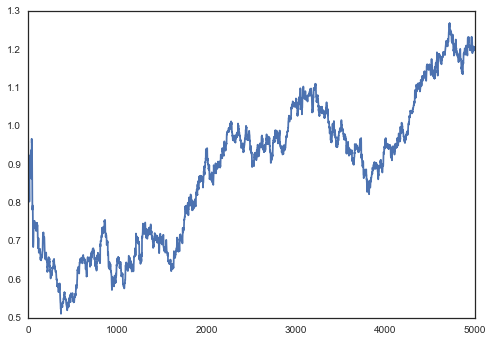

In [12]:
plt.plot(stateCoefs[:,100])

3.MAP estimation
* It's clear that the state of the variable did not converge.

The MAP value for beta 100 is: 0.946024232316


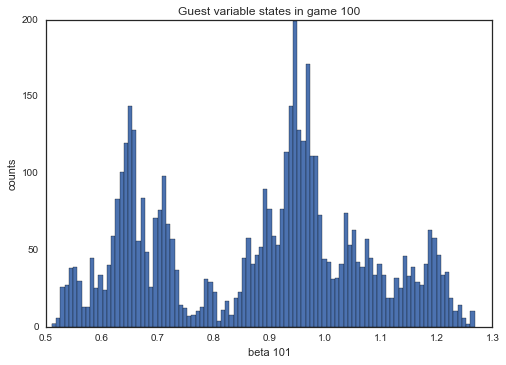

In [16]:
for i in range(100,101):
    plt.figure(i)
    p_hist = plt.hist(stateCoefs[burn_in:,i], bins=100)
    plt.title("Guest variable states in game %s" %(i))
    plt.xlabel("beta %s" %(i+1))
    plt.ylabel("counts")
    p_map_index = np.argmax(p_hist[0])
    p_hist_bin_middle = 0.5*p_hist[1][:-1] + 0.5*p_hist[1][1:]
    p_map = p_hist_bin_middle[p_map_index]
    
    print "The MAP value for beta %s is: %s" %(i, p_map)

* It's not converging. We tried up to N_mcmc = 100,000, but the trace of the state is not convergent. So, I just took the average of the states and checked the contribution ranking. The below is the result.

In [17]:
mean_coefs = stateCoefs.mean(axis=0)
mean_b0, mean_bs, mean_g0, mean_gs = split_params(mean_coefs, N_players, N_teams)
contribute_off = np.argsort(-mean_bs)# * player_info['PTS'])

betas_df = player_info.loc[contribute_off]
betas_df['beta'] = mean_bs[contribute_off]
betas_df.head(15)

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Tm_Index,beta
410,James Ennis,Memphis Grizzlies,845059,SF,25,22,5,15.0,2.5,5.1,...,1.0,1.9,1.0,0.7,0.2,0.9,1.3,7.2,2,2.355143
349,Archie Goodwin,Phoenix Suns,1160160,PG,21,57,13,19.5,3.1,7.4,...,2.0,2.5,2.1,0.5,0.2,1.8,1.5,8.9,22,2.222903
464,Elliot Williams,Charlotte Hornets,80000,PG,26,5,0,9.0,0.4,2.0,...,0.6,0.8,0.8,0.0,0.0,0.2,0.4,1.6,18,2.106741
293,Lou Amundson,New York Knicks,1650000,PF,33,29,0,7.0,0.7,1.8,...,0.9,1.7,0.4,0.2,0.2,0.5,1.5,1.8,0,2.012828
164,Kris Humphries,Phoenix Suns,4600000,PF,30,53,17,15.8,2.3,5.6,...,3.0,4.1,0.7,0.3,0.4,0.7,1.8,6.5,22,1.961256
222,Dante Cunningham,New Orleans Pelicans,3000000,SF,28,80,46,24.6,2.3,5.2,...,2.2,3.0,1.0,0.5,0.4,0.5,2.2,6.1,24,1.889515
345,Marcus Thornton,Houston Rockets,1186000,SG,28,61,8,18.2,3.5,8.9,...,1.8,2.5,1.4,0.8,0.1,0.8,1.5,9.7,13,1.842698
452,Bryce Dejean-Jones,New Orleans Pelicans,169883,SG,23,14,11,19.9,2.0,4.9,...,2.9,3.4,1.1,0.7,0.1,0.8,1.2,5.6,24,1.838988
259,Jared Sullinger,Boston Celtics,2269260,PF,23,81,73,23.6,4.3,10.0,...,5.9,8.3,2.3,0.9,0.6,1.3,2.6,10.3,6,1.834914
167,Mike Dunleavy,Chicago Bulls,4500000,SF,35,31,30,22.7,2.5,6.1,...,2.4,2.7,1.3,0.5,0.3,0.8,2.1,7.2,11,1.807705


* The contribution ranking is very different from our expectation; we expected that players who have higher PTS would contribute more but that's not the case here. We thought it's maybe bacause of the possible correlation among players, which we simply ignored in the previous case. So, we constructed a covariance matrix where we assigned covariance among players in the same team; the covariance was randomly sampled from the gamma distribution to make sure that it's always positive. 

# when the performance each player is assumed to be correlated
1.Estimation of the latent variable states 

In [18]:
def covariance(gammaMean = 1.0, gammaScale = 1.0):
    dim = 2*(N_teams + N_players)
    mat = np.identity(dim)
    
    tmIndexBox = player_info['Tm_Index'].values

    for j in np.arange(len(player_info)):
        tmIdxThisPlayer = tmIndexBox[j]
        for x in np.arange(len(player_info)):
            if (x == j):
                continue
            
            if (tmIndexBox[x] == tmIdxThisPlayer):
                mat[N_teams + j, N_teams + x] = np.random.gamma(gammaMean, gammaScale, size=None)
                mat[2 * N_teams + N_players + j, 2* N_teams + N_players + x] = np.random.gamma(gammaMean, gammaScale, size=None)
    return mat
# print correlation()[2*N_teams + N_players][2 * N_teams + N_players:2 * N_teams + N_players +N_players]

In [19]:
# game_index = 10
N_mcmc = 5000
burn_in = 100
dim = 2*(N_teams + N_players)

start_time = time.time()
stateCoefs2 = ess(covariance(), logLik, N_mcmc, burn_in)
elapsed = time.time() - start_time
print("Elapsed Time (sec): %f" %elapsed)

Elapsed Time (sec): 472.037000


D:\Users\Jim Hyungmok Son\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: covariance is not positive-semidefinite.


2.Trace plot of one of the states of the latent variables

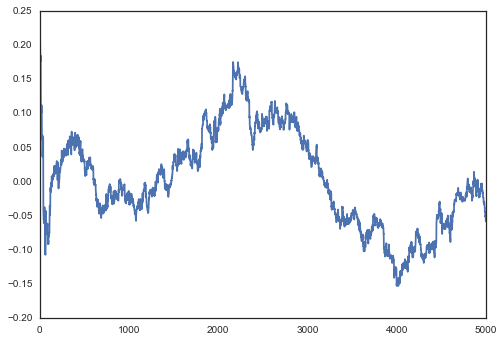

In [20]:
plt.plot(stateCoefs2[:,100])

In [21]:
# last_coefs = stateCoefs2[100,:]
# last_b0, last_bs, last_g0, last_gs = split_params(last_coefs, N_players, N_teams)

mean_coefs2 = stateCoefs2.mean(axis=0)
mean_b0, mean_bs, mean_g0, mean_gs = split_params(mean_coefs2, N_players, N_teams)
contribute_off = np.argsort(-mean_bs)# * player_info['PTS'])

betas_df = player_info.loc[contribute_off]
betas_df['beta'] = mean_bs[contribute_off]
betas_df.head(15)

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Tm_Index,beta
28,Klay Thompson,Golden State Warriors,15500000,SG,25,80,80,33.3,8.1,17.3,...,3.4,3.8,2.1,0.8,0.6,1.7,1.9,22.1,10,2.573698
362,Wesley Johnson,Los Angeles Clippers,1100600,SF,28,80,9,20.8,2.6,6.4,...,2.6,3.1,0.6,1.1,0.7,0.7,2.2,6.9,16,2.500265
109,Lou Williams,Los Angeles Lakers,7000000,SG,29,67,35,28.5,4.2,10.3,...,2.1,2.5,2.5,0.9,0.3,1.6,1.6,15.3,1,2.446283
149,Darren Collison,Sacramento Kings,5013559,PG,28,74,15,30.0,5.1,10.5,...,1.9,2.3,4.3,1.0,0.1,1.8,1.9,14.0,23,2.430970
452,Bryce Dejean-Jones,New Orleans Pelicans,169883,SG,23,14,11,19.9,2.0,4.9,...,2.9,3.4,1.1,0.7,0.1,0.8,1.2,5.6,24,2.330314
355,Kyle Anderson,San Antonio Spurs,1142879,SF,22,78,11,16.0,1.8,3.8,...,2.8,3.1,1.6,0.8,0.4,0.8,1.2,4.5,3,2.185933
95,George Hill,Indiana Pacers,8000000,PG,29,74,73,34.1,4.4,10.0,...,3.2,4.0,3.5,1.1,0.2,1.4,2.0,12.1,28,2.026693
323,Bobby Portis,Chicago Bulls,1391160,PF,20,62,4,17.8,3.0,7.0,...,3.5,5.4,0.8,0.4,0.4,0.9,1.6,7.0,11,1.983849
214,Austin Rivers,Los Angeles Clippers,3100000,SG,23,67,7,21.9,3.4,7.7,...,1.6,1.9,1.5,0.7,0.1,0.9,2.0,8.9,16,1.975429
15,Paul Millsap,Atlanta Hawks,19000000,PF,30,81,81,32.7,6.2,13.2,...,6.6,9.0,3.3,1.8,1.7,2.4,2.9,17.1,26,1.856782


3.MAP estimation

The MAP value for beta 100 is: -0.0269793126602


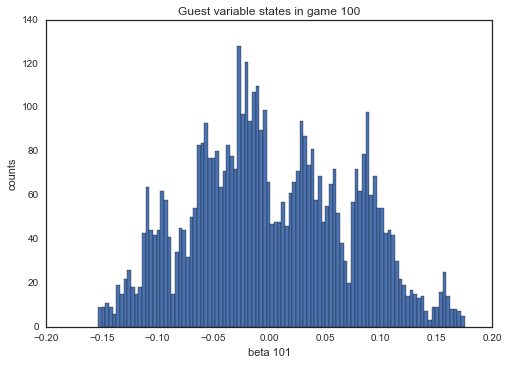

In [23]:
for i in range(100,101):
    plt.figure(i)
    p_hist = plt.hist(stateCoefs2[burn_in:,i], bins=100)
    plt.title("Guest variable states in game %s" %(i))
    plt.xlabel("beta %s" %(i+1))
    plt.ylabel("counts")
    p_map_index = np.argmax(p_hist[0])
    p_hist_bin_middle = 0.5*p_hist[1][:-1] + 0.5*p_hist[1][1:]
    p_map = p_hist_bin_middle[p_map_index]
    
    print "The MAP value for beta %s is: %s" %(i, p_map)

* Having a covariance matrix, it seems the result is more convergent compared to the previous case where the players were indenpendent. Even from the ranking of players based on the offensive contribution factors, we have more number of high profile player who have high PTS and AST this time. However, the level of convergence based on the MAP estimatino is not satisfactory. Maybe, by having a better covarinace matric which can reflect the actual correlation among players, we would do better sampling.